# Workflow for Examplary Truck Transport Routing

In this application, we showcase the capability for pre-process network graphs and simplify their topologies

The workflow is structured as follows:
1. Import relevant modules / tools / packages
2. Demand and Supply Distribution
3. Prepare Distance Matrices
4. Optimization of Routing
5. Postprocessing

# 1. Import relevant modules / tools / packages

The main techno-economic assumptions are based on Reuß et al. (2019) https://doi.org/10.1016/j.apenergy.2019.04.064

In [1]:
from HIM.workflow.scenarioExample import *

##  Import relevant modules / tools

"dataPath" is the internal storage folder of the python package. To save into a new folder, please adjust the "pathSave" variable.

In [2]:
from HIM import dataHandling as sFun
from HIM import optiSetup as optiFun
from HIM import hscTotal
from HIM import plotFunctions as pFun
from HIM.workflow import preprocFunc as preFun   

In [3]:
## Frame assumptions
penetration=0.25

## Import Georeference Data

To showcase the model, an example dataset is stored on the data folder of the package with randomized Production and Fueling station locations

In [4]:
dataPathExample=path.join(dataPath,"HSCExampleInputs")

In [5]:
pathDist= path.join(dataPathExample,"area")
pathFS = path.join(dataPathExample,"randomFuelingStations")
pathSource = path.join(dataPathExample,"randomSources")
pathStreet= path.join(dataPathExample,"StreetLines")

### Import Demand, Sources and Connections (streets and candidate grid)

In [6]:
District = sFun.import_shp(pathDist, crs=crs, name="C")
Fueling = sFun.import_shp(pathFS, crs=crs, name="F")
Source=sFun.import_shp(pathSource, crs=crs, name="S")
(distStreet, StreetsPointsNew) = preFun.importDLMStreets(pathStreet, speed, crs)

define standard plotting routine

In [7]:
def plot_shape(figsize=(7,10), facecolor="white"):
    unary=gpd.GeoSeries([District.unary_union])
    ax=unary.plot(facecolor=facecolor, figsize=figsize)
    ax.xaxis.set_ticklabels(["" for x in ax.xaxis.get_ticklabels()])
    ax.yaxis.set_ticklabels(["" for x in ax.yaxis.get_ticklabels()])
    ax.axis("off")
    ax.set_aspect("equal")
    return ax

# 2. Demand and Supply Distribution

First, we match the fueling station locations with the district polygons

In [8]:
spatial_index=Fueling.sindex
for (areaID, areaValue) in District.iterrows():
    possible_matches_index = list(spatial_index.intersection(areaValue["geometry"].bounds))
    possible_matches = Fueling.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(areaValue["geometry"])]
    Fueling.loc[precise_matches.index,"ID_C"]=areaID
    District.loc[areaID, "nFuelStat"]=len(precise_matches.index)

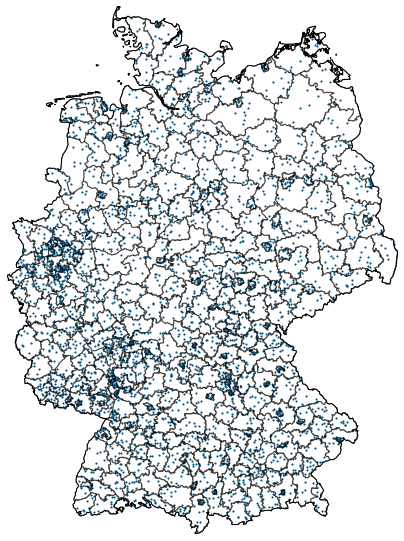

In [9]:
ax=plot_shape()
District.boundary.plot(ax=ax, color="black", alpha=0.5)
Fueling.plot(ax=ax, marker=".", markersize=5)
plt.show()

Second, we calculate the demand of each fueling station by utilizing the demand of each district and distribute it to the fueling stations inside of each district

In [10]:
Centroid=District.copy()
Centroid.geometry=Centroid.centroid
Centroid["FCEV"]=Centroid["vehicles"]*penetration
Centroid["H2Demand_kt"]=Centroid["FCEV"]*specificDemand*mileage*1e-6
fuelingMax_kt_a=fuelingMax_kg_d/1e6*365
Centroid["minFS"]=np.ceil(Centroid["H2Demand_kt"]/fuelingMax_kt_a)
Centroid["realFS"]=Centroid["nFuelStat"]
Centroid["H2Demand_kt_F"]= Centroid["H2Demand_kt"]/Centroid["minFS"]
Centroid.loc[Centroid["minFS"]==0,["H2Demand_kt_F", "H2Demand_kt"]]=0
District["H2Demand_kt"]=Centroid["H2Demand_kt"].values
totalH2Demand=Centroid["H2Demand_kt"].sum()

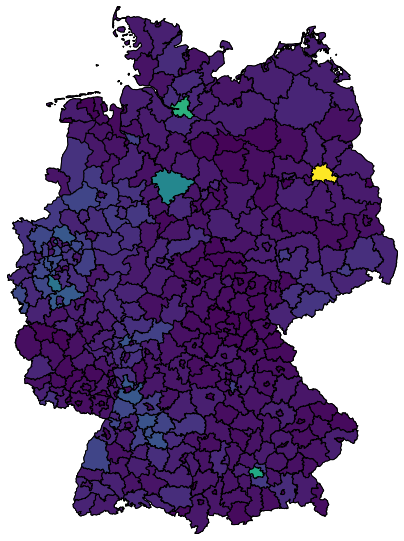

In [11]:
ax=plot_shape()
District.plot(column="H2Demand_kt", ax=ax)
plt.show()

then, we calculate the minimum number of fueling stations necessary and select the necessary ones

In [12]:
try: 
    fuelingMax_kt_a=totalH2Demand/targetFS
    fuelingMax_kg_d=fuelingMax_kt_a*1e6/365
except:
    fuelingMax_kt_a=fuelingMax_kg_d/1e6*365
Centroid["minFS"]=np.ceil(Centroid["H2Demand_kt"]/fuelingMax_kt_a)
##%%
Centroid["H2Demand_kt_F"]= Centroid["H2Demand_kt"]/Centroid["minFS"]

In [13]:
FuelingNew=preFun.getChosenStations(Fueling=Fueling, Centroid=Centroid, weightFtoF=weightFtoF)

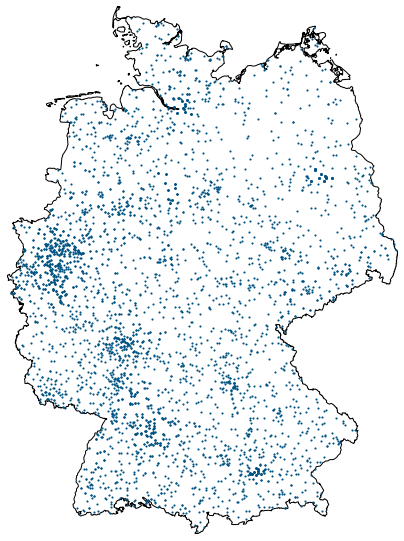

In [14]:
ax=plot_shape()
FuelingNew.plot(ax=ax, marker=".", markersize=5)
plt.show()

## Prepare source capacity

For the sources, we have to set the capacity. To simplify it for this example, we set the total hydrogen demand as maximal capacity.

In [15]:
Source["H2ProdCap_kt"]=totalH2Demand

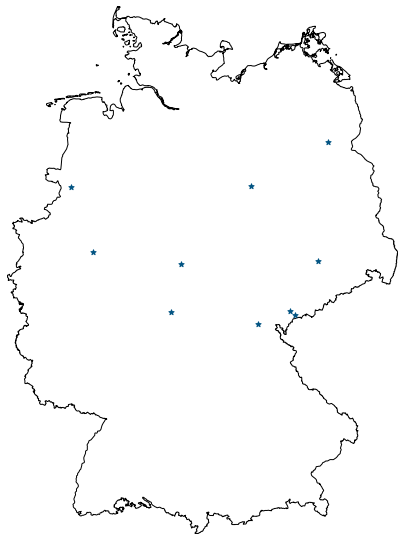

In [16]:
ax=plot_shape()
Source.plot(ax=ax, marker="*", markersize=30)
plt.show()

## Grid data

For the street grid data, the exemplary dummy values are equally distributed points

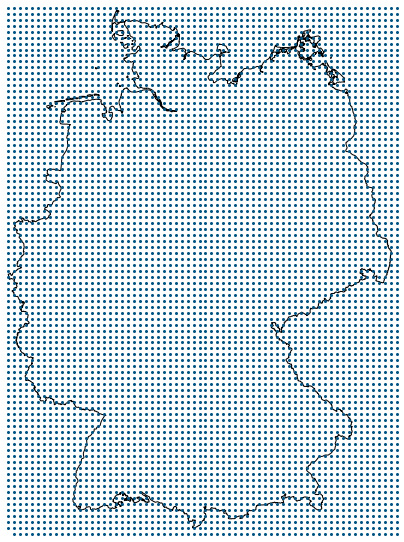

In [17]:
ax=plot_shape()
StreetsPointsNew.plot(ax=ax, marker=".")
plt.show()

# 3. Prepare Distance Matrices

In [18]:
#Prepare coordinates
truckCoords=Source.geometry.append(FuelingNew.geometry).append(StreetsPointsNew.geometry)

if the gas grid is available as linestring data and know for usage, the distGtoG can be created directly from the gas grid data without setting up a new matrix. SInce we have just points give, we create the distance matrix via euclidian distances of near neighbours

In [19]:
distMatTruck=sFun.distMatrix(Source, StreetsPointsNew, kNN=1, weight=1.3).append(sFun.distMatrix(FuelingNew, StreetsPointsNew, kNN=1,weight=1.3))

In [20]:
distMatTruck["time"]=distMatTruck["weightedDistance"]/speed["urban"]

In [21]:
distMatTruck=distMatTruck.append(distStreet)

# 4. Optimization of routing

## Truck routing

In [22]:
GraphTruck=optiFun.PipeNetWork()
GraphTruck.initializeEdges(distMatTruck)

nx.set_node_attributes(GraphTruck, "productionMax", Source.H2ProdCap_kt.to_dict())
nx.set_node_attributes(GraphTruck, "demand", FuelingNew["H2Demand_kt_F"].to_dict())

In [23]:
#Initializing the optimization
GraphTruck.initOptiTruck(weight=weight)

Next step: Running the model

In [24]:
GraphTruck.optModel()

Academic license - for non-commercial use only
Read LP format model from file C:\Alles\sciebo\Python\HIM\apps\tmp37u5awwz.pyomo.lp
Reading time = 0.73 seconds
x90406: 46871 rows, 90406 columns, 207599 nonzeros
Changed value of parameter MIPgap to 0.005
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter timeLimit to 2000.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter logfile to GurobiLog.txt
   Prev: gurobi.log  Default: 
Changed value of parameter threads to 7
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter Heuristics to 0.5
   Prev: 0.05  Min: 0.0  Max: 1.0  Default: 0.05
Optimize a model with 46871 rows, 90406 columns and 207599 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Pres

And finally, catching the results from the optimization

In [25]:
resultsTruckNodes=GraphTruck.getProductionNodes()
resultsEdgesTruck=GraphTruck.getEdgesAsGpd(truckCoords, "truck")
#%%
Source["truck_kt_a"]=resultsTruckNodes
Source["truck_kg_d"]=Source["truck_kt_a"]*1e6/365
resultsEdgesTruck["edge"]=[not ("Street" in x[0] and "Street" in x[1]) for x in resultsEdgesTruck.index]

Since we want to have the same system for the distribution option for pipeline/trailer systems, we need to calculate the truck optimization again.

# 5. Postprocessing

First, we have to design the pathways

In [26]:
hscPathways={}

hscPathways["truck"]=[["GH2-Truck"],
                      ["LH2-Truck"],
                      ["LOHC-Truck"]]

Since we have two transport system, we have to divide between transmission and distribution for all options and set the right dataframe

In [27]:
pipelineDistance=[[0,0]]

truckDistance=[resultsEdgesTruck,
               0]

sourceDf={"truck":Source["truck_kg_d"]}

Finally, we can run the Resultmanager

In [28]:
Results={}
i=0
for hscPathwayType in sorted(hscPathways.keys()):
    listCapacities=[resultsEdgesTruck["capacity"].values*1e6/365]
    for listHSC in hscPathways[hscPathwayType]:
        cumCost=0

        Results[i]=hscTotal.HSC(listHSC,
                                 dfTable,
                                 listCapacities,
                                 totalH2Demand*1e6,
                                 truckDistance=truckDistance,
                                 pipelineDistance=pipelineDistance,
                                 targetCars=0,
                                 beeline=beeline)

        Results[i].calcHSC(cumCost=cumCost)
        display(Results[i].dfHSCRes)
        i+=1

,TOTEX,CAPEX,fixOPEX,varOPEX,invest,cumCost,technology,nTrucks,pipeLength,Loss,electricityRES,electricityGrid,NaturalGas,Diesel,overCapacity,CO2Emissions[kg/kg],primaryEnergy[MJ/kg]
Transport,1.3215,0.654,0.5055,0.162,4.690669e+09,1.3215,GH2-Truck,5720.3281,0,1.0,0.0,0.0,0.0,0.6912,1,0.2198,2.9859


,TOTEX,CAPEX,fixOPEX,varOPEX,invest,cumCost,technology,nTrucks,pipeLength,Loss,electricityRES,electricityGrid,NaturalGas,Diesel,overCapacity,CO2Emissions[kg/kg],primaryEnergy[MJ/kg]
Transport,0.4572,0.2553,0.1604,0.0414,1.851800e+09,0.4572,LH2-Truck,1815.4898,0,1.0,0.0,0.0,0.0,0.1768,1,0.0562,0.7638


,TOTEX,CAPEX,fixOPEX,varOPEX,invest,cumCost,technology,nTrucks,pipeLength,Loss,electricityRES,electricityGrid,NaturalGas,Diesel,overCapacity,CO2Emissions[kg/kg],primaryEnergy[MJ/kg]
Transport,0.6369,0.1837,0.3432,0.11,1.204094e+09,0.6369,LOHC-Truck,3884.1734,0,1.0,0.0,0.0,0.0,0.4693,1,0.1492,2.0275


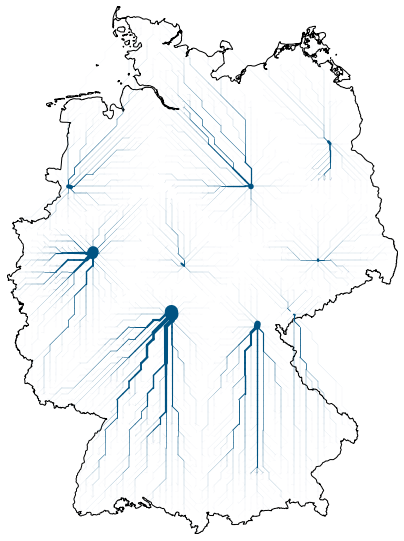

In [29]:
ax=plot_shape()
resultsEdgesTruck.plot(ax=ax, linewidth=resultsEdgesTruck["capacity"]*0.5e-1)
plt.show()